# Basic CNN Model (PyTorch)
This notebook is based on the book Hands-On Transfer Learning with Python by Dipanjan Sarkar, Raghav Bali, and Tamoghna Ghosh.

The following code demonstrates how to create a basic Convolutional Neural Network (CNN) model using PyTorch.
Realizing the training on the Cats vs Dogs dataset.
How the full dataset takes a lot of time to train, we will use a smaller subset of the dataset for demonstration purposes.

After the training, we will visualize the training and validation accuracy and loss using Matplotlib. Saving the trained model for future use.


In [1]:
"""
Author: Leandro Stival
"""
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset

c:\Users\stiva001\AppData\Local\anaconda3\envs\ml_class\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants and device
Set image dimensions, batch size, epochs, and compute device.

In [2]:
IMG_DIM = (128, 128)
BATCH_SIZE = 10
EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


## Load Hugging Face dataset and split
Hugging Face 🤗 Datasets library is used to load the Cats vs Dogs dataset.
Hugging face is a popular platform for sharing datasets and models, particularly in the field of natural language processing and computer vision.

[Hugging Face Datasets](https://huggingface.co/datasets)  
[Hugging Face Models](https://huggingface.co/models)

The original script loads `microsoft/cats_vs_dogs` and splits into training and validation sets.

In [3]:
from datasets import concatenate_datasets

# Load dataset (this will download if not present)
ds_full = load_dataset("microsoft/cats_vs_dogs")['train']

# Select 500 cats and 500 dogs
cats = ds_full.filter(lambda x: x['labels'] == 0).select(range(500))
dogs = ds_full.filter(lambda x: x['labels'] == 1).select(range(500))

# Concatenate and shuffle
subset = concatenate_datasets([cats, dogs]).shuffle(seed=42)

# Split into train and validation
ds = subset.train_test_split(test_size=0.2, seed=42)
hf_train = ds['train']
hf_val = ds['test']
print('HF train size:', len(hf_train), 'HF val size:', len(hf_val))

Filter: 100%|██████████| 23410/23410 [00:40<00:00, 575.43 examples/s]


HF train size: 800 HF val size: 200


## PyTorch Dataset wrapper for HF dataset
A small Dataset class that converts dataset examples to PIL images (if needed), applies transforms, and returns tensors. Labels are returned as float tensors for BCELoss usage.

In [4]:
class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item['image']
        if not isinstance(img, Image.Image):
            # dataset Image feature should already be PIL, but ensure conversion if needed
            img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(item['labels'])  # 0=cat, 1=dog
        return img, torch.tensor(label, dtype=torch.float32)

## Transforms and DataLoaders
Define simple resize + to-tensor transforms and create DataLoaders. Adjust `num_workers` if running on Windows with incompatibilities.

In [5]:
# transforms
train_transform = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.ToTensor(),
])
val_transform = train_transform

train_dataset = HFDataset(hf_train, transform=train_transform)
val_dataset = HFDataset(hf_val, transform=val_transform)

# On Windows, num_workers=0 is the most compatible; original used 4.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print('Train dataset size:', len(train_dataset), '\tValidation dataset size:', len(val_dataset))

Train dataset size: 800 	Validation dataset size: 200


## Model definition
This mirrors the original Keras architecture converted to PyTorch: several Conv2d blocks followed by fully connected layers and a sigmoid output for binary classification.

In [6]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_DIM[0]//8) * (IMG_DIM[1]//8), 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)

model = BasicCNN().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model

BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Training loop
Standard PyTorch training loop that records loss and accuracy for train and validation sets.

In [7]:
# training loop
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = (outputs.detach() > 0.5).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    train_losses.append(running_loss/total)
    train_acc.append(correct/total)

    model.eval()
    with torch.no_grad():
        vloss = 0.0
        vcorrect = 0
        vtotal = 0
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            vloss += loss.item() * imgs.size(0)
            preds = (outputs > 0.5).float()
            vcorrect += (preds == labels).sum().item()
            vtotal += imgs.size(0)
        val_losses.append(vloss/vtotal if vtotal else 0)
        val_acc.append(vcorrect/vtotal if vtotal else 0)

    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{EPOCHS} - loss: {train_losses[-1]:.4f} - acc: {train_acc[-1]:.4f} - val_loss: {val_losses[-1]:.4f} - val_acc: {val_acc[-1]:.4f}')

Epoch 1/50 - loss: 0.6981 - acc: 0.4800 - val_loss: 0.6844 - val_acc: 0.5550
Epoch 5/50 - loss: 0.5875 - acc: 0.6837 - val_loss: 0.7423 - val_acc: 0.6100
Epoch 10/50 - loss: 0.1416 - acc: 0.9400 - val_loss: 2.3439 - val_acc: 0.5900
Epoch 15/50 - loss: 0.0343 - acc: 0.9888 - val_loss: 4.7484 - val_acc: 0.6000
Epoch 20/50 - loss: 0.0021 - acc: 1.0000 - val_loss: 5.6577 - val_acc: 0.5800
Epoch 25/50 - loss: 0.0004 - acc: 1.0000 - val_loss: 7.5944 - val_acc: 0.6000
Epoch 30/50 - loss: 0.0049 - acc: 1.0000 - val_loss: 8.2835 - val_acc: 0.5850
Epoch 35/50 - loss: 0.0002 - acc: 1.0000 - val_loss: 10.0035 - val_acc: 0.6100
Epoch 40/50 - loss: 0.0001 - acc: 1.0000 - val_loss: 10.0867 - val_acc: 0.6150
Epoch 45/50 - loss: 0.0000 - acc: 1.0000 - val_loss: 10.1212 - val_acc: 0.6000
Epoch 50/50 - loss: 0.0000 - acc: 1.0000 - val_loss: 10.1428 - val_acc: 0.6000


## Plot training curves and save model
Plot accuracy and loss, then save the trained model weights.

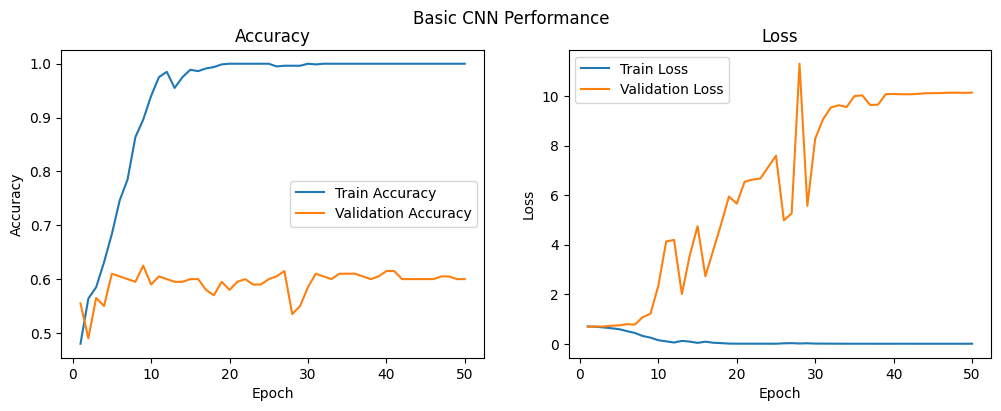

Model saved to CTRL_OA_basic_cnn_drop_pytorch_hf.pth


In [8]:
epochs = list(range(1, len(train_acc)+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_acc, label='Train Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses, label='Train Loss')
ax2.plot(epochs, val_losses, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('Basic CNN Performance')
plt.show()

# save model
torch.save(model.state_dict(), 'CTRL_OA_basic_cnn_drop_pytorch_hf.pth')
print('Model saved to CTRL_OA_basic_cnn_drop_pytorch_hf.pth')